Hi Football Lovers,
This is an analysis about football results of National Teams, inspired by a dataset I found here on Kaggle (https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017). This dataset includes 40,838 results of international football matches starting from the very first official match in 1972, up to 2019.
So, I want to say thank you to Mart Jürisoo, and I hope you will enjoy this work.
I also encourage you to leave a comment below, any tips or consideration will be really welcomed.

Before starting, I have to point out that for making the analysis a relevant one I choose to exclude National Teams that have less than 100 games played when the calculation involved ratios.

Firstly, I exploit python and its main libraries to extract from the dataset the national teams the history of football has declared successful, and the other ones who have collected more defeats than victories throughout the years. 


In [ ]:
import pandas as pd
import numpy as np

match= pd.read_csv('../input/international-football-results-from-1872-to-2017/results.csv')

#put date in correct format and set it as the index
date= pd.to_datetime(match.date.values)
match['date']=date
match.set_index('date', inplace=True)


#get the coloumn of results (wins, ties and losses)
win= np.where(match.home_score > match.away_score, 'win', None)
tie=np.where(match.home_score == match.away_score, 'tie', None)
loss= np.where(match.home_score < match.away_score, 'loss', None)

results=pd.DataFrame([win, tie, loss]).T
results
x=[value[value != None]  for value in results.values]
#x=np.array(x)
#x=x.tolist()
match['result']= x
match['result']=np.squeeze(match.result.tolist())

#get the number of goals
match['goals']= match.home_score + match.away_score


#home
home_teams=match.groupby(['home_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})


home_matches=[]
for team in home_teams.home_team:
    tot_matches= home_teams[home_teams.home_team== team]['count'].sum()
    home_matches.append(tot_matches)
   
home_teams['home_matches']=home_matches
home_teams['pct_home_victory']= home_teams['count']/ home_teams['home_matches']


#away
away_teams=match.groupby(['away_team','result']).count()['city'].sort_values(ascending=False).reset_index().rename(columns={'city': 'count'})
away_teams.replace({'loss': 'win', 'win':'loss'}, inplace=True) #loss means victory for the away team

away_tot_matches=[]
for team in away_teams.away_team:
    tot_matches= away_teams[away_teams.away_team == team]['count'].sum()
    away_tot_matches.append(tot_matches)

away_teams['away_matches']= away_tot_matches
away_teams['pct_victory_away'] = away_teams['count']/away_teams['away_matches']


#adjusting terminology and index
home_teams.rename(columns={'result': 'home_results', 'count': 'home_count'}, inplace=True)
home_teams.set_index('home_team', inplace=True)
away_teams.rename(columns={'result': 'away_results', 'count': 'away_count'}, inplace=True)
away_teams.set_index('away_team', inplace=True)


#defining winners and loosers
home_winners= home_teams[home_teams.home_results=='win']
away_winners= away_teams[away_teams.away_results=='win']
home_losers= home_teams[home_teams.home_results=='loss']
away_losers= away_teams[away_teams.away_results=='loss']


#merging datasets
winners=pd.merge(home_winners, away_winners, left_index=True, right_index=True, how='inner')
losers=pd.merge(home_losers, away_losers, left_index=True, right_index=True, how='inner')
losers.rename(columns={'pct_home_victory': 'pct_home_defeats', 'pct_victory_away': 'pct_away_defeats'}, inplace=True)

winners['tot_count']= winners.home_count + winners.away_count
winners['tot_matches']= winners.home_matches + winners.away_matches
winners['tot_pct_victory']= winners.tot_count/winners.tot_matches
winners= winners[winners.tot_matches >= 100] #getting only clubs who have played at least 100 matches
winners_pct= winners[['pct_home_victory', 'pct_victory_away', 'tot_pct_victory']]

losers['tot_count']= losers.home_count + losers.away_count
losers['tot_matches']= losers.home_matches + losers.away_matches
losers['tot_pct_defeats']= losers.tot_count/losers.tot_matches
losers= losers[losers.tot_matches >= 100] #getting only clubs who have played at least 100 matches
losers_pct= losers[['pct_home_defeats', 'pct_away_defeats', 'tot_pct_defeats']]


#total percentage
winners_pct.sort_values(by='tot_pct_victory', ascending=False)
winners_pct=np.round(winners_pct*100, 2)
winners_pct['tot_count']= winners.tot_count
winners_pct['tot_matches']= winners.tot_matches


losers_pct=np.round(losers_pct*100, 2)
losers_pct['tot_count']= losers.tot_count
losers_pct['tot_matches']= losers.tot_matches


winners_pct.sort_values(by='tot_pct_victory', ascending=False)



In this first section, after a little bit of data cleaning, I have, as I said before, defined winners and losers.
By taking advantage of Tableau, I am going to showcase you who are the best and the worst football teams in terms of results:

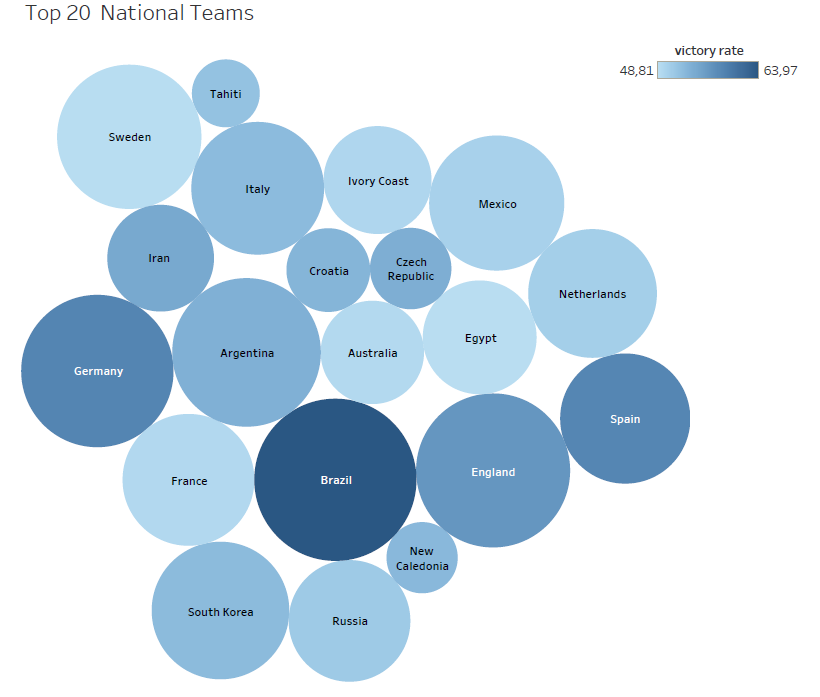

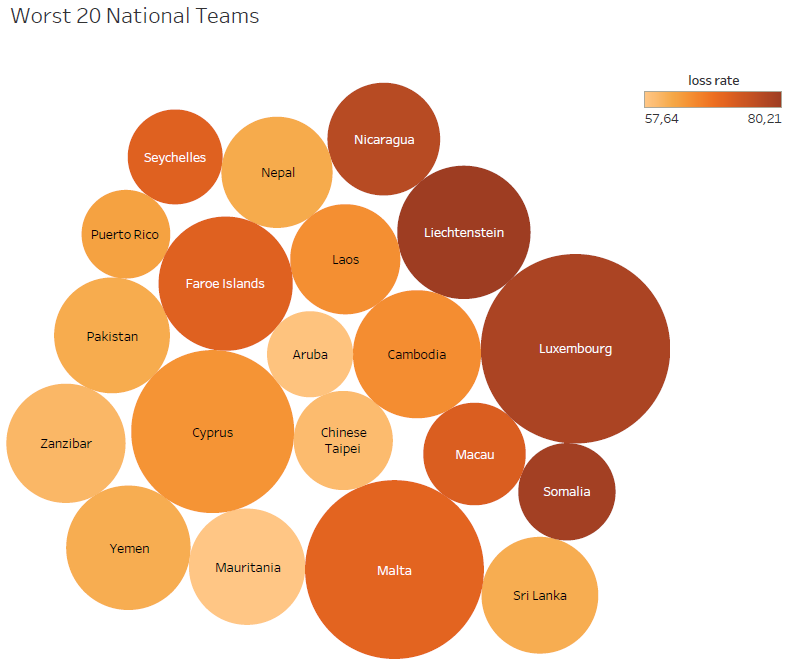

Here, the size of the bubbles represents the number of victories/losses associated to a specific team, while the colour is the winning/loss rate, so the number of victories/losses has been divided by the totality of the games played.

For instance, Brazil in the first chart is depicted by a bubble whose size is somewhat similar to the English one, which is a little bit lighter though. It simply means that the victory count is more or less the same, but England, which is the country who has created the football game, has played more games than Brasil.
For this reason, the Brazilian victory rate is higher than the English one, and this causes a darker bubble's colour.

Finally, with 625 victories over 997 games, we can declare Brasil the champion above any others. On the other hand, 
Liechtenstein with 154 losses over 194 games played is the worst National football team in history in terms of results.

In [ ]:
#discover goal and history

home_matches=match.groupby('home_team').sum().rename(columns={'home_score': 'goals_scored_home', 'away_score' : 'goals_taken_home'})

away_matches=match.groupby('away_team').sum().rename(columns={'home_score': 'goals_taken_away', 'away_score' : 'goals_scored_away'})

#merging 

score= pd.merge(home_matches, away_matches, how='inner', right_index= True, left_index=True)

#creating calculated fields
score['tot_goals_scored']= score['goals_scored_home'] + score['goals_scored_away']
score['tot_goals_taken']= score['goals_taken_home'] + score['goals_taken_away']
score['diff_goals_tot'] = score['tot_goals_scored'] - score['tot_goals_taken']
score.drop(columns=['neutral_x', 'goals_x', 'neutral_y', 'goals_y'], inplace=True)

#get the match count (only teams with 100 match played are taken)
score=pd.merge(score, winners[['home_matches', 'away_matches', 'tot_matches']], how='inner', right_index=True, left_index=True)

#compute ratios
score['home_goals_pct'] = score['goals_scored_home']/ score['home_matches']
score['away_goals_pct'] = score['goals_scored_away']/ score['away_matches']
score['home_goals_taken_pct'] = score['goals_taken_home']/ score['home_matches']
score['away_goals_taken_pct'] = score['goals_taken_away']/ score['away_matches']
score['tot_goals_scored_pct'] = score['tot_goals_scored']/ score['tot_matches']
score['tot_goals_taken_pct'] = score['tot_goals_taken']/ score['tot_matches']
score_pct= score[['home_goals_pct', 'away_goals_pct', 'home_goals_taken_pct', 'away_goals_taken_pct',
                 'tot_goals_scored_pct', 'tot_goals_taken_pct', 'diff_goals_tot']]

score_pct.sort_values(by='diff_goals_tot', ascending=False)

#join winners with score

total_ratio= pd.merge(score_pct, winners_pct, how='inner', right_index=True, left_index=True)
total_ratio= pd.merge(total_ratio, losers_pct, how='inner', right_index=True, left_index=True)

score_pct.sort_values(by='diff_goals_tot', ascending=False)

correlation= total_ratio[['tot_goals_scored_pct', 'tot_goals_taken_pct', 
                          'tot_pct_victory','tot_pct_defeats']].corr()





In the previous code section, I checked how many goals every single team has scored and has taken, and I computed the difference between them. Then I divided the values by the number of games played to obtain ratios, which are values more comparable to each other.


The next maps display respectively winning/loss rate and goal difference. 
I decided to use diverging colors in both cases to r the strong similarity. 


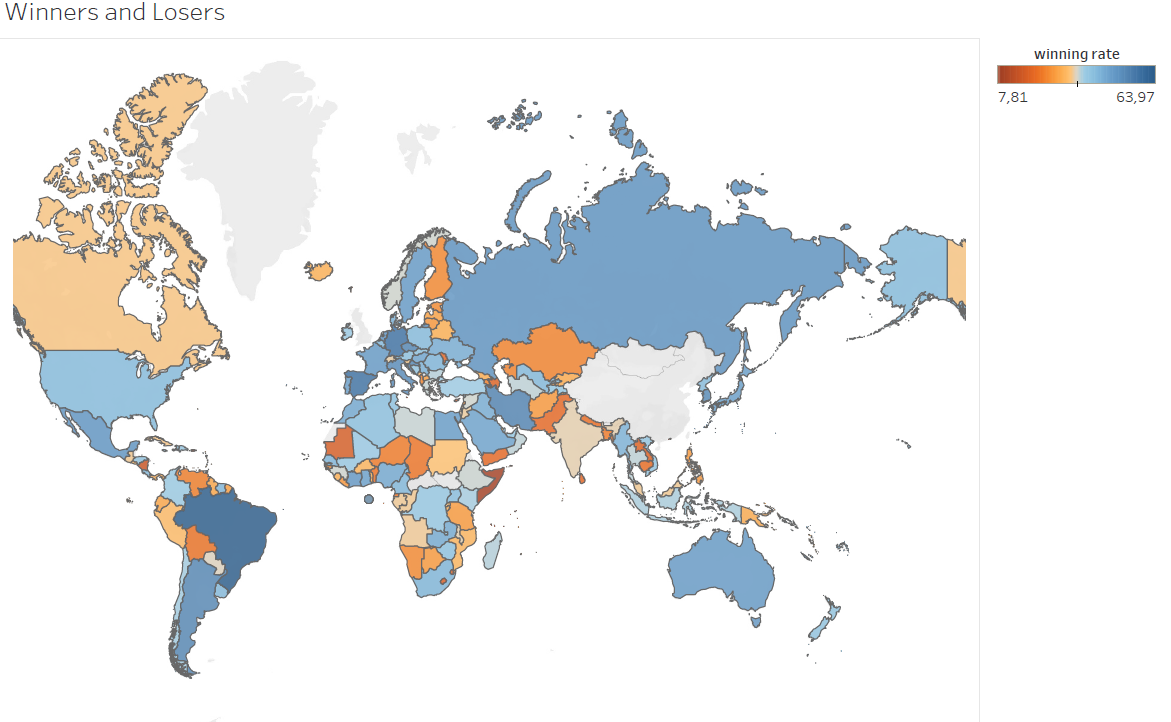


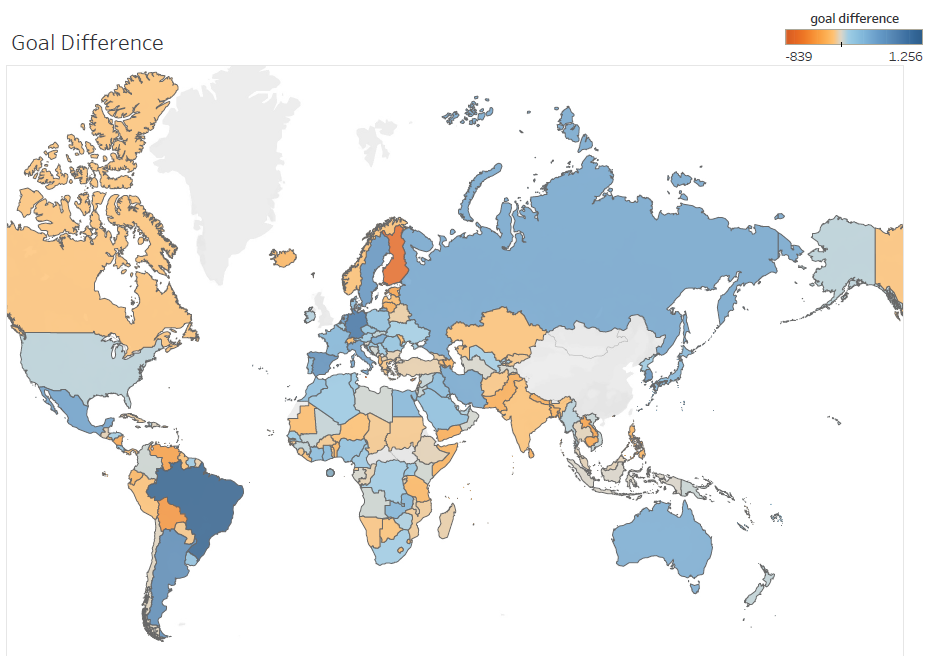

Its seems to be the same map showed twice, but If you look carefully, you can spot a few slight colour's differences.
Anyway, we can doubtlessly state that there is a strong connection between the winning/losing rate and goal difference. Someone could think it is an obvious conclusion, but it doesn't: for instance, if a team lost 9 games with a single goal difference, and then won the 10th 10-0; the winning rate is 10%, but the goal difference is +1. Anyway, let's compute the Pearson's correlation: 

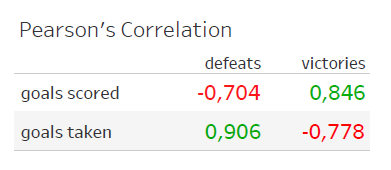

We can do even more. Let's leverage machine learning to build a model which tries to predict the winning/losing rate from the goals data we have collected so far:

In [ ]:
#machine learining to predict victory/loss rate
total_ratio.corr()['tot_pct_victory'] #check correlation
train = np.array(total_ratio.iloc[:, :7])
test= np.array(total_ratio['tot_pct_victory'])


**We only selected data with information about goals scored and taken as features, to avoid data leakage**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=42)

Let's try a simple liner regression:

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

In [ ]:
lr.score(X_test, y_test)

The model performed pretty well, but it seems to be a little bit underfitting. So let's try a more complex one, like the Random Forest Regressor:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_estimators=200, max_features=2, max_depth=20, bootstrap=True, random_state=1)
rf.fit(X_train, y_train)
rf.score(X_train,y_train)

In [ ]:
rf.score(X_test,y_test)

This model performs indisputably better than the previous one, so I am pretty satisfied.

Football lovers often debate whether is more important to build a solid defense or to be able to score a lot of goals to win tough, long-term competitions like a national championship or the renowned Champions League.
The table up there tries to figure out a solution to this endless question: in fact, there is a stronger correlation between defeats and goals taken than the one between victories and goals scored.
In a nutshell, if you want to build a successful football team, you have to start from the defense.


In [ ]:
#goals through the years

year_goals= match.groupby(by=[match.index.year]).sum()['goals']
year_match= match.groupby(by=[match.index.year]).count()['neutral']
year=pd.DataFrame([year_goals, year_match]).T.rename(columns={'neutral': 'matches'})

#normalize
year['goals_match'] = year.goals/year.matches 
year=np.round(year, 2)




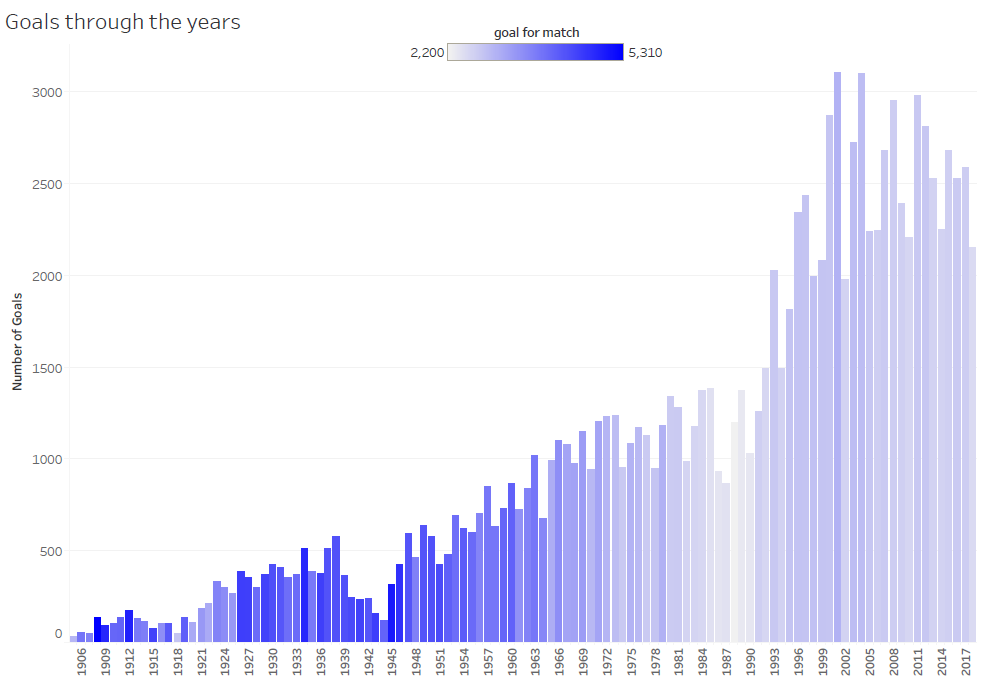

Nostalgic people always point out that through the years football has changed. They usually say sentences like: 
> "in the past, there were fewer tactics preparation and football was more entertaining because we saw more goals". 

This is only partially true: as we can see from the bar chart, as years go by bar become higher and lighter. It means that the number of goals increases through the year, but the notoriety of the sport too, and more.
In other words, nowadays more goals are scored simply because much more games are played in a year. But the average number of goals scored in a football match has gradually decreased through the year, perhaps exactly for the radical tactical change that nostalgic people don't appreciate.


*I want to say thank you to everyone who has read my words until here, I hope you enjoyed throughout this football journey.*
*I remember you to leave a comment below if you are willing to do it, it would be highly appreciated anyway.
 Bye for now*.